In [2]:
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/state-farm-distracted-driver-detection.zip" -d "/content/drive/MyDrive/Colab Notebooks/StateFarm"

warning [/content/drive/MyDrive/Colab Notebooks/state-farm-distracted-driver-detection.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/drive/MyDrive/Colab Notebooks/state-farm-distracted-driver-detection.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
error:  expected central file header signature not found (file #102166).
  (please check that you have transferred or created the zipfile in the
  appropriate BINARY mode and that you have compiled UnZip properly)


# The Road Ahead
The notebook is broken into separate steps as shown below.

Step 0: Import Datasets    
Step 1: Create and train a CNN to Classify Driver Images (from Scratch)    
Step 2: Train a CNN with Transfer Learning (Using Fine-tuned VGG16)    
Step 3: Kaggle Results

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

import keras
import numpy
from keras.preprocessing.image import ImageDataGenerator

# Step 0: Import Datasets
## Import Driver Dataset    
In the following code cell, we create a instance of ImageDataGenerator which does all preprocessing operations on images that we are going to feed to our CNN

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255, validation_split=0.2)
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)

In the following code, we are loading only 32 images at once into memory and performing all the preprocessing operations on loaded images. The flow_from_directory loads a defined set of images from the location of images, instead of loading all images at once into memory.

- train_generator contains training set
- val_generator contains validation set

In [5]:
train_data = '/content/drive/MyDrive/Colab Notebooks/StateFarm/state-farm-distracted-driver-detection/imgs/train'
test_data = '/content/drive/MyDrive/Colab Notebooks/StateFarm/state-farm-distracted-driver-detection/imgs/test'

train_generator = train_datagen.flow_from_directory(
      train_data,
      target_size=(224, 224),
      batch_size = 32,
      class_mode = "categorical",
      subset="training")

val_generator = train_datagen.flow_from_directory(
      train_data,
      target_size=(224,224),
      batch_size=32,
      class_mode = 'categorical',
      subset="validation")

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [6]:
from PIL import Image

ac_labels = [
    "c0: safe driving",
    "c1: texting - right",
    "c2: talking on the phone - right",
    "c3 : texting - left",
    "c4 : talking on the phone - left",
    "c5 : operating the radio",
    "c6 : drinking",
    "c7 : reaching behind",
    "c8 : hair and makeup",
    "c9 : talking to passenger"
]

In [7]:
imgs, labels = next(train_generator)

## Dataset Exploration
Following code block explores and reveals the dataset

In [8]:
import functools

def list_counts(start_dir):
    lst = sorted(os.listdir(start_dir))
    out = [(fil, len(os.listdir(os.path.join(start_dir, fil)))) for fil in lst if os.path.isdir(os.path.join(start_dir, fil))]
    return out

out = list_counts(train_data)
labels, counts = zip(*out)
print("Total number of images : ", functools.reduce(lambda a,b : a+b, counts))
out

Total number of images :  22424


[('c0', 2489),
 ('c1', 2267),
 ('c2', 2317),
 ('c3', 2346),
 ('c4', 2326),
 ('c5', 2312),
 ('c6', 2325),
 ('c7', 2002),
 ('c8', 1911),
 ('c9', 2129)]

## Data Visualization
Following code block. displays images and their respective labels of training/ validation dataset

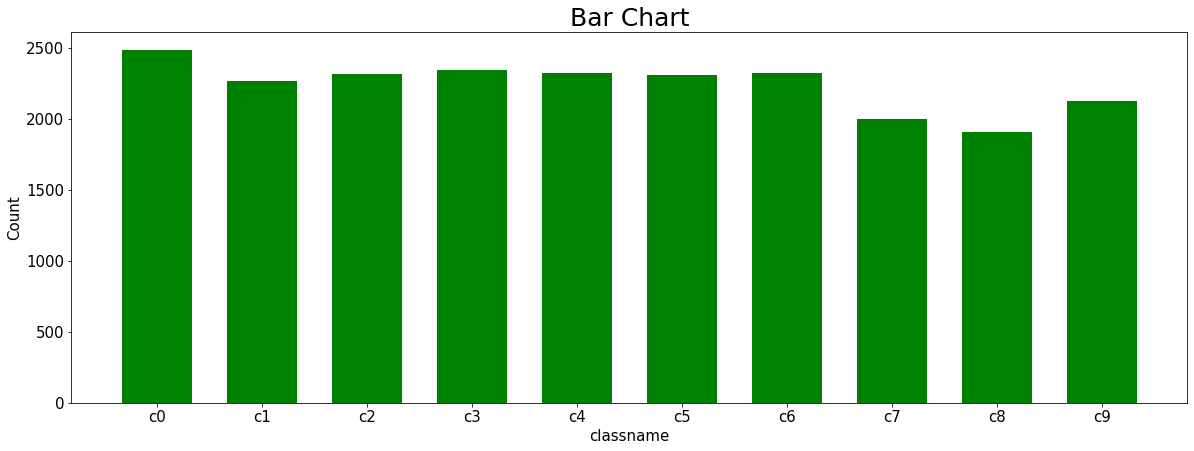

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

y = np.array(counts)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="green")

plt.title("Bar Chart", size=25)
plt.xlabel('classname', size=15)
plt.ylabel('Count', size=15)

plt.show()

Label :  c0: safe driving


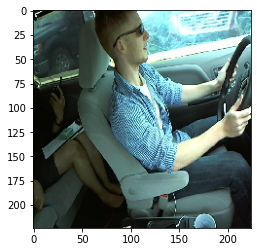

Label :  c0: safe driving


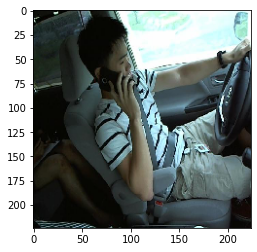

Label :  c0: safe driving


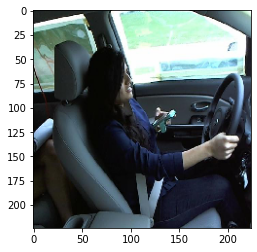

In [10]:
def showImages(imgs ,inlabels=None, single=True):
    if single:
        aim = (imgs * 255 ).astype(np.uint8)
        img = Image.fromarray(aim)
        if labels is not None:
            print("Label : ", ac_labels[np.argmax(inlabels)])
        plt.imshow(img)
        plt.show()
    else:
        for i,img in enumerate(imgs):
            lbl = None
            if inlabels is not None:
                lbl = labels[i]
            showImages(img, lbl)

ind = 3
showImages(imgs[:ind], inlabels=labels[:ind], single = False)

# Step 1: Create a CNN to Classify Driver Images (from Scratch)

We have created 6 convolutional layers with 1 max pooling layer and 1 GlobalAveragePooling in between.     
Filters were increased from 8 to 512 in total convolutional layers.      
Also dropout was used along with Global average pooling layer before using the fully connected layer.      
Number of nodes in the last fully connected layer were setup as 10 along with softmax activation function.       
ReLU activation function was used for all other layers.     

6 convolutional layers were used to learn hierarchy of high level features.     
Max pooling layer is added to reduce the dimensionality.       
Global Average Pooling layer is added to reduce the dimensionality as well as the matrix to row vector.     
This is because fully connected layer only accepts row vector. Dropout layers were added to reduce overfitting and ensure that the network generalizes well.     
The last fully connected layer with softmax activation function is added to obtain probabilities of the prediction.     

In [11]:
from keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras import regularizers

In [12]:
input_layer = Input(shape=(224, 224, 3))

conv = Conv2D(filters=8, kernel_size=2)(input_layer)
conv = Conv2D(filters=16, kernel_size=2, activation='relu')(conv)
conv = Conv2D(filters=32, kernel_size=2, activation='relu')(conv)
conv = MaxPooling2D()(conv)

conv = Conv2D(filters=64, kernel_size=2, activation='relu')(conv)
conv = Conv2D(filters=128, kernel_size=2, activation='relu')(conv)
conv = Conv2D(filters=512, kernel_size=2, activation='relu')(conv)

conv = GlobalAveragePooling2D()(conv)
dense = Dense(units=500, activation='relu')(conv)
dense = Dropout(0.1)(dense)
dense = Dense(units=100, activation='relu')(dense)
dense = Dropout(0.1)(dense)
output = Dense(units=10, activation='softmax')(dense)

model = Model(inputs=input_layer, outputs = output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 223, 223, 8)       104       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      528       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 221, 221, 32)      2080      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      8256      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 108, 108, 128)     32896 

### Compile CNN from scratch Model

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model
The model is trained in the code cell below. Model checkpointing is used to save the model that attains the best validation loss.

In [15]:
#model.load_weights('best_model_1.hdf5')
checkpoint = ModelCheckpoint('best_model_1.hdf5', save_best_only=True, verbose=1)

history = model.fit(train_generator, steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data = val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[checkpoint])

Epoch 1/10
561/561 [==============================] - 239s 341ms/step - loss: 2.3008 - accuracy: 0.1016 - val_loss: 2.2523 - val_accuracy: 0.1571

Epoch 00001: val_loss improved from inf to 2.25229, saving model to best_model_1.hdf5
Epoch 2/10
561/561 [==============================] - 188s 334ms/step - loss: 2.1391 - accuracy: 0.1843 - val_loss: 1.8087 - val_accuracy: 0.2857

Epoch 00002: val_loss improved from 2.25229 to 1.80869, saving model to best_model_1.hdf5
Epoch 3/10
561/561 [==============================] - 186s 332ms/step - loss: 1.6810 - accuracy: 0.3260 - val_loss: 1.3129 - val_accuracy: 0.4805

Epoch 00003: val_loss improved from 1.80869 to 1.31289, saving model to best_model_1.hdf5
Epoch 4/10
561/561 [==============================] - 187s 332ms/step - loss: 1.3027 - accuracy: 0.4784 - val_loss: 1.1290 - val_accuracy: 0.5575

Epoch 00004: val_loss improved from 1.31289 to 1.12896, saving model to best_model_1.hdf5
Epoch 5/10
561/561 [==============================] - 18

In the following code block, we are plotting the loss value of training and validation to see whether the model is learning or not

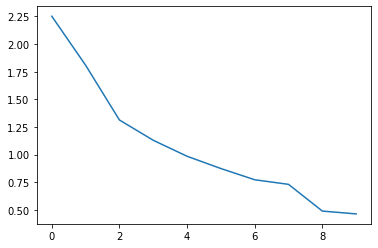

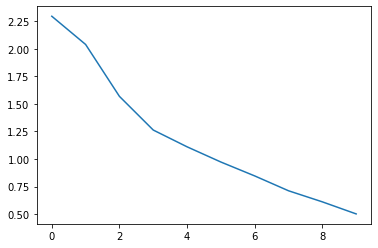

In [16]:
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['loss'])

### Loading test dataset into memory and predict on test images
Following code block contains a method, that loads all test images into memory by batches, each batch with 32 images when it is called each time

In [32]:
# !ls /content/drive/MyDrive/Colab Notebooks/StateFarm/state-farm-distracted-driver-detection/imgs/

import os
# model.load_weights('../input/best_model_1.hdf5')

#Test Images
batch_index = 0
files_list = os.listdir("/content/drive/MyDrive/Colab Notebooks/StateFarm/state-farm-distracted-driver-detection/imgs/test/")

def load_test_images(batch_size=32, src="/content/drive/MyDrive/Colab Notebooks/StateFarm/state-farm-distracted-driver-detection/imgs/test/"):
    global batch_index, files_list
    imgs_list = files_list[batch_index:batch_index+batch_size]
    batch_index += len(imgs_list)
    batch_imgs = []

    for img_name in imgs_list:
        img = Image.open(src+img_name)
        im = img.resize((224,224))
        batch_imgs.append(np.array(im)/255.)
    # plt.imshow()
    # plt.show()
    return np.array(batch_imgs)


Following code block predicts on test images by loading 32 images a batch using load_test_images function

In [33]:
#Test Images write
import sys
preds_list = np.array([])
batch_index=0
batch_size = 32

while True:
    tst_imgs = load_test_images(batch_size=batch_size)
    if(tst_imgs.shape[0] <= 0  ):
        print("Batchsize is less : ",batch_index)
        break
    preds = model.predict(tst_imgs)
    print("\r {},  batch_size : {}, nth_batch/all_batch : {}/{}".format(preds_list.shape,batch_size, batch_index, len(files_list)),end="")    
    sys.stdout.flush()
    if len(preds_list) == 0:
        preds_list = np.array(preds)
    else:
        preds_list = np.append(preds_list, preds, axis=0)

 (79712, 10),  batch_size : 32, nth_batch/all_batch : 79726/79726Batchsize is less :  79726


### Convert the predicted output to submittable output file

In [44]:
titles = "img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9".split(",")
names = pd.DataFrame(files_list[:len(preds_list)])
names.columns=['img']

df = pd.DataFrame(preds_list)
df.columns=titles[1:]
df['img'] = names['img']
df = df[titles]
df.tail()
df.to_csv("submission.csv", index=False)

### Predictions by scratch CNN on some sample images
- Seems like the predictions are not so accurate because of less training

label :  c5 : operating the radio


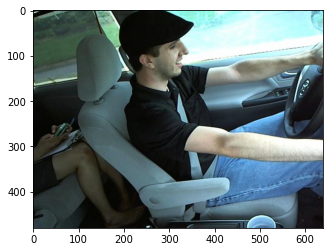

label :  c1: texting - right


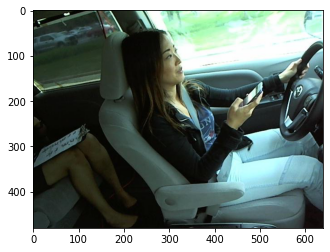

label :  c5 : operating the radio


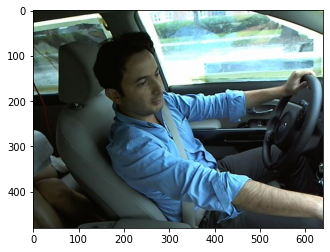

In [46]:
indices = [1,24,35]

for index in indices:
    cls = np.argmax(list(df.iloc[index][1:]))
    print("label : ",ac_labels[cls])
    im_test = Image.open('/content/drive/MyDrive/Colab Notebooks/StateFarm/state-farm-distracted-driver-detection/imgs/test/'+df.iloc[index]['img'])
    plt.imshow(np.array(im_test))
    plt.show()

# Step 2: Train a CNN with Transfer Learning (Using Fine-tuned VGG16 Model)
- In the following steps, we are going to load a VGG16 model, without top Fully connected layers, with its trained weights 
- Then we are going add Fully Connected Layers on top of GlobalAveragePooling layer with Dropout layers in between
- The following code block contains a method load_VGG16, which loads VGG16 model with weights loaded when weights file location is given

In [66]:
def load_VGG16(weights_path=None, no_top=True):

    input_shape = (224, 224, 3)

    #Instantiate an empty model
    img_input = Input(shape=input_shape)   # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    x = GlobalAveragePooling2D()(x)
    vmodel = Model(img_input, x, name='vgg16')
    if weights_path is not None:
        print("Weights have been loaded.")
        vmodel.load_weights(weights_path)

    return vmodel

In the following code block, we have added 3 Dense layers with dropout layers on top of VGG16 CNN model.

In [67]:
vgg_model_raw = load_VGG16('/content/drive/MyDrive/Colab Notebooks/StateFarm/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg_model = vgg_model_raw.output
#vgg_model = Flatten()(vgg_model)
vgg_model = Dense(5000, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(vgg_model)
#vgg_model = Dropout(0.1)(vgg_model)
#vgg_model = Dense(1000, activation='relu')(vgg_model)
vgg_model = Dropout(0.1)(vgg_model)
vgg_model = Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(vgg_model)
vgg_model = Dropout(0.1)(vgg_model)
vgg_model = Dense(10, activation='softmax')(vgg_model)
vgg_m = Model(inputs=vgg_model_raw.input, outputs=vgg_model)

Weights have been loaded.


In [68]:
vgg_m.layers[16].get_weights()

[array([[[[-1.12610648e-03, -1.39102731e-02, -4.15291899e-04, ...,
           -2.39090272e-03,  5.59418183e-03, -1.67810004e-02],
          [ 1.13813886e-02, -6.83033955e-04, -8.76976922e-03, ...,
           -8.44151899e-03, -3.70610040e-03,  1.24894250e-02],
          [ 2.18971120e-03,  1.76711346e-03,  1.23967733e-02, ...,
            1.34555586e-02,  1.07239345e-02,  5.72480168e-03],
          ...,
          [-8.70769471e-03,  4.26163105e-03, -7.06244586e-03, ...,
            1.54851489e-02,  4.63837199e-03,  7.84500409e-03],
          [-6.56485325e-04,  7.68889068e-03, -1.45298289e-03, ...,
           -7.35005224e-03, -3.10419098e-04,  8.47741403e-03],
          [ 5.95664885e-03, -3.27580003e-03, -5.32116368e-03, ...,
           -2.03936966e-03,  1.35865889e-03,  5.91904763e-03]],
 
         [[ 2.12769513e-03, -5.14811045e-03, -5.62243350e-03, ...,
           -1.31134260e-02,  4.88865655e-03, -1.01500070e-02],
          [ 1.17016789e-02, -7.15120370e-03, -8.39244854e-03, ...,
     

### Compile the vgg16 model with categorical crossentropy as loss function and SGD as optimizer

In [69]:
vgg_m.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(0.001), metrics=['accuracy'])

In [70]:
vgg_m.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

- Create a Checkpoint to save best weights, when loss in improvised
- Train the model for 10 epochs

In [82]:
checkpoint = ModelCheckpoint('vgg_model.h5', save_best_only=True, verbose=1)

history = vgg_m.fit(train_generator, steps_per_epoch=len(train_generator),
                   epochs=6,
                   validation_data = val_generator,
                   validation_steps=len(val_generator),
                   callbacks=[checkpoint] )

Epoch 1/6
561/561 [==============================] - 269s 479ms/step - loss: 0.0769 - accuracy: 0.9843 - val_loss: 0.0669 - val_accuracy: 0.9866

Epoch 00001: val_loss improved from inf to 0.06687, saving model to vgg_model.h5
Epoch 2/6
561/561 [==============================] - 265s 472ms/step - loss: 0.0684 - accuracy: 0.9867 - val_loss: 0.0544 - val_accuracy: 0.9913

Epoch 00002: val_loss improved from 0.06687 to 0.05444, saving model to vgg_model.h5
Epoch 3/6
561/561 [==============================] - 283s 504ms/step - loss: 0.0558 - accuracy: 0.9904 - val_loss: 0.0508 - val_accuracy: 0.9904

Epoch 00003: val_loss improved from 0.05444 to 0.05080, saving model to vgg_model.h5
Epoch 4/6
561/561 [==============================] - 264s 470ms/step - loss: 0.0509 - accuracy: 0.9911 - val_loss: 0.0447 - val_accuracy: 0.9929

Epoch 00004: val_loss improved from 0.05080 to 0.04474, saving model to vgg_model.h5
Epoch 5/6
561/561 [==============================] - 265s 473ms/step - loss: 0.0

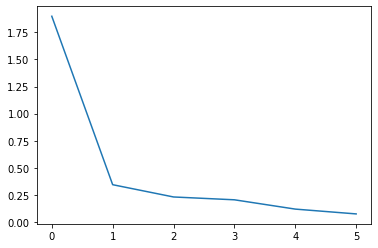

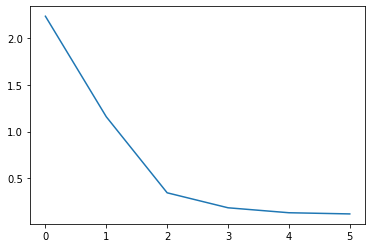

In [76]:
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['loss'])

Following method gives a batch of 32 images at each call, just like a **generator**

In [77]:
!ls

import os
#model.load_weights('../StateFarm/best_model_1.hdf5')

# Test Images
batch_index = 0

files_list = os.listdir('/content/drive/MyDrive/Colab Notebooks/StateFarm/state-farm-distracted-driver-detection/imgs/test')
def load_test_images_vgg(batch_size=32, src='/content/drive/MyDrive/Colab Notebooks/StateFarm/state-farm-distracted-driver-detection/imgs/test/'):
    global batch_index, files_list
    imgs_list = files_list[batch_index : batch_index+batch_size]
    batch_index += len(imgs_list)
    batch_imgs = []

    for img_name in imgs_list:
        img = Image.open(src+img_name)
        im = img.resize((224,224))
        batch_imgs.append(np.array(im)/255.)

    return np.array(batch_imgs)

best_model_1.hdf5  drive  sample_data  submission.csv  vgg_model.h5


In [78]:
# Test Images write

import sys
preds_list = np.array([])
batch_index = 0
batch_size = 32

mm_raw = load_VGG16()

mm_model = mm_raw.output
mm_model = Dense(5000,activation='relu', kernel_regularizer=regularizers.l2(0.00001))(mm_model)
mm_model = Dropout(0.1)(mm_model)
mm_model = Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.00001))(mm_model)
mm_model = Dropout(0.1)(mm_model)
mm_model = Dense(10, activation='softmax')(mm_model)
mm = Model(inputs=vgg_model_raw.input, outputs=vgg_model)

mm.load_weights('vgg_model.h5')

In [80]:
while True:
    tst_imgs = load_test_images_vgg(batch_size=batch_size)
    if(tst_imgs.shape[0] <=0):
        print("Batch size is less : ", batch_index)
        break
    preds = mm.predict(tst_imgs)
    print("\r {}. batch_size :{}, nth_batch/all_batch : {}/{}".format(preds_list.shape, batch_size, batch_index, len(files_list)), end="")
    sys.stdout.flush()

    if len(preds_list) == 0:
        preds_list = np.array(preds)
    else:
        preds_list = np.append(preds_list, preds, axis=0)


 (79680, 10). batch_size :32, nth_batch/all_batch : 79726/79726Batch size is less :  79726


In [83]:
titles = 'img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9'.split(",")
names = pd.DataFrame(files_list[:len(preds_list)])
names.columns=['img']

df = pd.DataFrame(preds_list)
df.columns=titles[1:]
df['img'] = names['img']
df = df[titles]
df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,2.885194e-01,3.419272e-01,4.464708e-03,2.071553e-03,1.490617e-03,0.000889,4.556848e-04,1.252631e-03,0.009325,0.349604
1,img_10.jpg,8.873664e-01,6.310076e-04,7.347907e-07,6.030463e-05,4.168906e-05,0.004501,2.529846e-06,2.050197e-05,0.000087,0.107289
2,img_100.jpg,2.145391e-03,4.868783e-01,5.207048e-02,2.373059e-05,1.196423e-05,0.000946,4.548137e-02,3.237511e-01,0.068404,0.020288
3,img_1000.jpg,2.294713e-07,9.814412e-09,4.789205e-09,1.239412e-10,1.428629e-08,0.999768,3.844371e-08,3.028546e-08,0.000191,0.000040
4,img_100000.jpg,2.076271e-05,2.160027e-06,6.637645e-07,1.339135e-06,2.992269e-05,0.999898,2.010482e-05,3.169977e-07,0.000015,0.000012


In [103]:
df.to_csv('sub_VGG16.csv', index=False)

label :  c1: texting - right


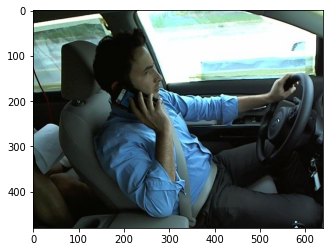

label :  c9 : talking to passenger


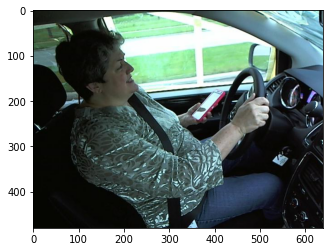

In [89]:
indices = [20,400]

for index in indices:
    cls = np.argmax(list(df.iloc[index][1:]))
    print("label : ", ac_labels[cls])
    im_test = Image.open('/content/drive/MyDrive/Colab Notebooks/StateFarm/state-farm-distracted-driver-detection/imgs/test/'+df.iloc[index]['img'])
    plt.imshow(np.array(im_test))
    plt.show()

In [105]:
!cat sub_VGG16.csv | head -8

img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_1.jpg,0.28851938,0.3419272,0.0044647083,0.0020715531,0.0014906168,0.0008892013,0.00045568476,0.0012526308,0.009325415,0.34960365
img_10.jpg,0.88736635,0.0006310076,7.347907e-07,6.030463e-05,4.1689058e-05,0.0045009996,2.5298461e-06,2.050197e-05,8.7340646e-05,0.10728863
img_100.jpg,0.0021453914,0.48687828,0.052070484,2.3730587e-05,1.1964234e-05,0.00094554084,0.045481373,0.32375112,0.068404034,0.020288102
img_1000.jpg,2.2947128e-07,9.8144115e-09,4.7892055e-09,1.2394125e-10,1.4286286e-08,0.9997683,3.8443705e-08,3.0285456e-08,0.00019103807,4.0297477e-05
img_100000.jpg,2.076271e-05,2.1600274e-06,6.6376447e-07,1.3391351e-06,2.992269e-05,0.99989843,2.0104822e-05,3.1699773e-07,1.4825427e-05,1.1557158e-05
img_100001.jpg,9.225169e-05,0.00043523018,4.8161855e-06,0.9988238,0.0005679504,1.8154733e-05,4.4500888e-05,7.9048874e-07,1.710838e-06,1.0783499e-05
img_100002.jpg,0.763855,0.023611506,0.037756555,0.0003545821,0.087288134,0.014936247,0.0032383145,0.000601607